# Inpainting with the deep decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Load image

In [2]:
path = './test_data/'
img_name = "poster"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_clean_var = np_to_var(img_np).type(dtype)

output_depth = img_np.shape[0]
img_mask_pil = Image.open('./test_data/mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * output_depth)
mask_var = np_to_var(mask_np).type(dtype)

## Generate inpainted image

In [3]:
img_noisy_var = img_clean_var * mask_var
img_noisy_np = var_to_np(img_noisy_var)

## Recover image

In [4]:
num_channels = [256]*5
net = decodernw(output_depth,num_channels_up=num_channels,upsample_first = True).type(dtype)

print("number of parameters: ", num_param(net))

rnd = 500
numit = 40000
rn = 0.005

mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0025,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        find_best=True,
                        )

number of parameters:  397312
shape:  [1, 256, 16, 16]
optimize with adam 0.0025


(-0.5, 511.5, 511.5, -0.5)

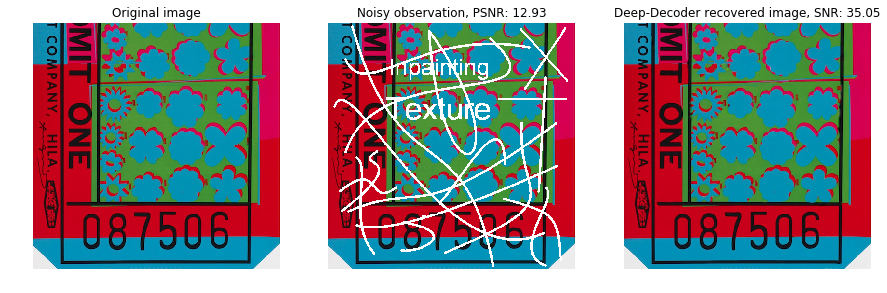

In [5]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1,img_np) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
myimgshow(ax2,img_noisy_np)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_np,img_noisy_np) )
ax2.axis('off')

out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
ax3 = fig.add_subplot(133)
myimgshow(ax3,out_img_np)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_np,out_img_np) ) 
ax3.axis('off')  